In [1]:
import torch
from torch import nn
import torchvision
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import random
import requests
import pandas as pd
from pathlib import Path
import numpy as np
import os
import zipfile
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, balanced_accuracy_score, classification_report
from tqdm.auto import tqdm
from collections import Counter

In [2]:
# set device by checking if gpu is available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


In [3]:
# set seed for reproducibilty
SEED = 50

random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
# # mount google drive
# from google.colab import drive
# drive.mount('/content/drive')

# # root directory where the food-11 zip file is located
# root_dir = 'drive/MyDrive/'

**DATA PREPROCESSING AND VISUALIZATION**

In [5]:
# extract the food-11 zip file
with zipfile.ZipFile('google_stock_price.zip', 'r') as zip_ref:
    zip_ref.extractall('google_stock_price/')

In [6]:
train_df = pd.read_csv('google_stock_price/Google_Stock_Price_Train.csv')
train_df.head(10)

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"
5,1/10/2012,313.70,315.72,307.30,621.43,"8,824,000"
6,1/11/2012,310.59,313.52,309.40,624.25,"4,817,800"
7,1/12/2012,314.43,315.26,312.08,627.92,"3,764,400"
8,1/13/2012,311.96,312.30,309.37,623.28,"4,631,800"
9,1/17/2012,314.81,314.81,311.67,626.86,"3,832,800"


In [7]:
# data pre-processing
train_df['Volume'] = train_df['Volume'].str.replace(',', '')
train_df = train_df[['Open', 'High', 'Low', 'Close', 'Volume']].apply(pd.to_numeric, errors='coerce')
train_df.dropna(inplace=True)

scaler = StandardScaler()

train_scaled_data = scaler.fit_transform(train_df)

print(train_scaled_data.shape)

(1149, 5)


In [8]:
# test_df = pd.read_csv('google_stock_price/Google_Stock_Price_Test.csv')
# test_df.head(10)

In [9]:
class StockDataset(Dataset):
    def __init__(self, data, N):

        self.data = data

        self.N = N

    def __len__(self):
        return len(self.data) - self.N

    def __getitem__(self, idx):
        # Get the sequence of features for the last N days
        x = self.data[idx:idx + self.N, :]
        # Get the closing price of the next day as the target
        y = self.data[idx + self.N, 3]

        # Convert to PyTorch tensors
        x = torch.tensor(x, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.float32)

        return x, y

In [10]:
# Define your parameters
N = 30  # Number of days to look back
batch_size = 32  # Batch size for DataLoader

# Instantiate the dataset
train_data = StockDataset(train_scaled_data, N)
#test_data = StockDataset(test_df, N)

In [11]:
# Create the DataLoader
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
#test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [12]:
x,y = next(iter(train_dataloader))

print(x.shape,y.shape)

torch.Size([32, 30, 5]) torch.Size([32])


**TRAINING**

In [13]:
# function to train the model
def train(model, dataloader, criterion, optimizer):
    model.train()    # Set the model to training mode

    epoch_loss = 0  # Accumulate loss for each epoch

    for x, y in dataloader:
        x, y = x.to(device), y.to(device)

        # Forward pass
        preds = model(x)
        preds = preds.squeeze()  # Ensure predictions have the same shape as y_batch

        # Compute the loss
        loss = criterion(preds, y)

        optimizer.zero_grad()  # Zero the gradients

        # Backward pass and optimization step
        loss.backward()
        optimizer.step()

        # Accumulate loss for reporting
        epoch_loss += loss.item()

    # Print the average loss for each epoch
    avg_loss = epoch_loss / len(dataloader)

    return avg_loss

In [14]:
# function to test the model
def test(model, dataloader, criterion):
    model.eval()

    epoch_loss = 0  # Accumulate loss for each epoch

    for x, y in dataloader:
        x, y = x.to(device), y.to(device)

        # Forward pass
        preds = model(x)
        preds = preds.squeeze()  # Ensure predictions have the same shape as y_batch

        # Compute the loss
        loss = criterion(preds, y)

        # Accumulate loss for reporting
        epoch_loss += loss.item()

    # Print the average loss for each epoch
    avg_loss = epoch_loss / len(dataloader)

    return avg_loss

In [15]:
# function to plot the predicted values and actual values
def evaluate(model, dataset):
    true = []
    preds = []

    model.eval()

    with torch.no_grad():
        for i in range(len(dataset)):
            x,y = dataset[i]

            x = x.unsqueeze(0)

            pred = model(x)

            true.append(y.item())
            preds.append(pred.item())

    plt.figure(figsize=(12, 6))
    plt.plot(true, label='Actual Stock Prices')
    plt.plot(preds, label='Predicted Stock Prices', linestyle='--')
    plt.legend()
    plt.show()

**BASELINE**

In [16]:
class Baseline(nn.Module):
    def __init__(self, feature_size, hidden_dim):

        super().__init__()

        self.rnn = nn.RNN(feature_size,
                          hidden_dim,
                          batch_first=True)

        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):

        # embedded = [sent len, batch size, emb dim]

        output, hidden = self.rnn(x)

        hidden = hidden.squeeze()

        out = self.fc(hidden)

        return out

In [17]:
feature_size = 5
hidden_dim = 8

model = Baseline(feature_size, hidden_dim).to(device)

In [18]:
optimizer = torch.optim.Adam(model.parameters())

criterion = nn.MSELoss()

In [19]:
epochs = 20

In [20]:
for epoch in range(epochs):

    # Print the average loss for each epoch
    train_loss = train(model, train_dataloader, criterion, optimizer)
    #test_loss = test(model, test_dataloader, criterion)

    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f}")

Epoch 10 | Train Loss: 0.0400
Epoch 20 | Train Loss: 0.0251


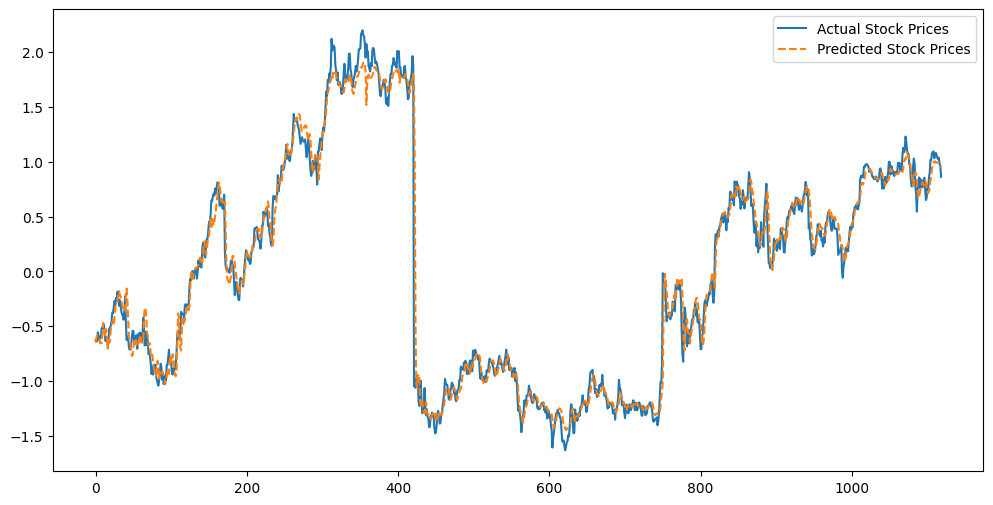

In [21]:
evaluate(model, train_data)

**LSTM**

In [22]:
class LSTM(nn.Module):
    def __init__(self, feature_size, hidden_dim, num_layers):

        super().__init__()

        self.rnn = nn.LSTM(feature_size,
                           hidden_dim,
                           batch_first=True,
                           num_layers=num_layers)

        self.fc = nn.Linear(hidden_dim*2, 1)

    def forward(self, x):

        # embedded = [sent len, batch size, emb dim]

        output, (hidden,cell) = self.rnn(x)

        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)

        out = self.fc(hidden)

        return out

In [23]:
feature_size = 5
hidden_dim = 64
num_layers = 2

model = LSTM(feature_size, hidden_dim, num_layers).to(device)

In [24]:
optimizer = torch.optim.Adam(model.parameters())

criterion = nn.MSELoss()

In [25]:
epochs = 50

In [26]:
for epoch in range(epochs):

    # Print the average loss for each epoch
    train_loss = train(model, train_dataloader, criterion, optimizer)
    #test_loss = test(model, test_dataloader, criterion)

    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f}")

Epoch 10 | Train Loss: 389374.9471
Epoch 20 | Train Loss: 389374.9471
Epoch 30 | Train Loss: 389374.9471
Epoch 40 | Train Loss: 389374.9471
Epoch 50 | Train Loss: 389374.9471


In [27]:
true = []
preds = []

model.eval()

with torch.no_grad():
    for i in range(len(train_data)):
        x,y = train_data[i]

        x = x.unsqueeze(0)

        pred = model(x)

        true.append(y.item())
        preds.append(pred.item())

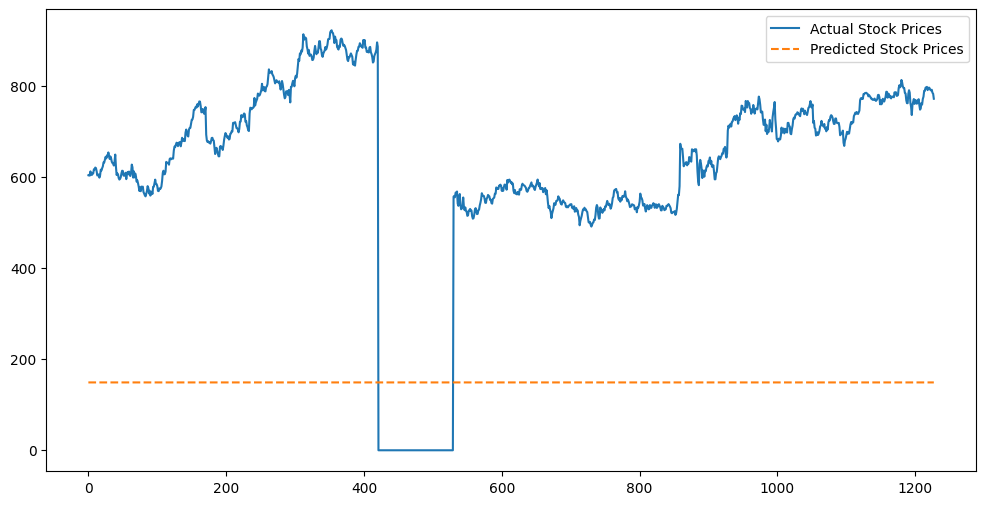

In [28]:
plt.figure(figsize=(12, 6))
plt.plot(true, label='Actual Stock Prices')
plt.plot(preds, label='Predicted Stock Prices', linestyle='--')
plt.legend()
plt.show()

**GRU**

In [ ]:
class GRU(nn.Module):
    def __init__(self, feature_size, hidden_dim, num_layers):

        super().__init__()

        self.rnn = nn.GRU(feature_size,
                           hidden_dim,
                           batch_first=True,
                           num_layers=num_layers)

        self.fc = nn.Linear(hidden_dim*2, 1)

    def forward(self, x):

        # embedded = [sent len, batch size, emb dim]

        output, hidden = self.rnn(x)

        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)

        out = self.fc(hidden)

        return out

In [ ]:
feature_size = 5
hidden_dim = 64
num_layers = 2

model = GRU(feature_size, hidden_dim, num_layers).to(device)

In [ ]:
optimizer = torch.optim.Adam(model.parameters())

criterion = nn.MSELoss()

In [ ]:
epochs = 50

In [ ]:
for epoch in range(epochs):

    # Print the average loss for each epoch
    train_loss = train(model, train_dataloader, criterion, optimizer)
    #test_loss = test(model, test_dataloader, criterion)

    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f}")